In [1]:
import os
from Utils.read_coord import kml_coord
from Utils.sentinal_request import senti_api

#from Utils.sentinal_request_landSat import senti_api as landSat

from Utils.forest_cover import *
#from Utils.seques_forecast import plot_SEQ
from datetime import datetime
from dateutil.relativedelta import relativedelta
import glob
from utils import plot_image

## Read KML file

In [2]:
file_path = input('Enter kml file path: ')
print(file_path)
#C:\Users\Harith\EngenuityAI\SPE\SPE-development\sentinal\gAMPOLA TEST SITE 2.kml
#C:\Users\User\OneDrive - Engenuity (Pvt) Ltd\Github\SPE-testing\test_kml_files\AmazonSPE.kml
if os.path.exists(file_path):
    print('The file exists')

    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

        #print(lines)
else:
    print('The specified file does NOT exist')

Enter kml file path: C:\Users\User\OneDrive - Engenuity (Pvt) Ltd\Github\SPE-testing\test_kml_files\AmazonSPE.kml
C:\Users\User\OneDrive - Engenuity (Pvt) Ltd\Github\SPE-testing\test_kml_files\AmazonSPE.kml
The file exists


In [3]:
# getting polygon coordinates
poly_coord = kml_coord(file_path)

## Sentinel req

In [4]:
img_senti,resol = senti_api(poly_coord)

Cloud Pixel:  0.0  km2


## Landsat req

In [52]:
from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import numpy as np
import pandas as pd

def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['lat','long'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    return bbox

bbox_generated = bbox_cord(poly_coord)

final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly_coord]}, crs=CRS.WGS84)

resolution =15
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

#date range
current_date = datetime.today().strftime('%Y-%m-%d')
past_date = datetime.today() - relativedelta(months=12)
past_date = past_date.strftime('%Y-%m-%d')

from sentinelhub import SHConfig
config = SHConfig()
evalscript_all_bands = """
    //VERSION=3
    function setup() {
  return {
    input: ["B05","B02", "B03", "B04"],
    output: { bands: 4 }
  };
}

    function evaluatePixel(sample) {
        return [sample.B05,
                sample.B02,
                sample.B03,
                sample.B04,
];
    }
"""
#32 bit Tiff output wuth 4 bands
request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,          
            time_interval=('2022-08-01', '2022-10-26'),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            other_args={"dataFilter": {"maxCloudCoverage": 20}},
        ),
    ],
        responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=final_bbox,
    size=box_size,
    geometry = geometry,
    config=config,
)

print(past_date,current_date)

#API request
all_bands_response = request_all_bands.get_data()

Image shape at 15 m resolution: (289, 297) pixels
2021-11-15 2022-11-15


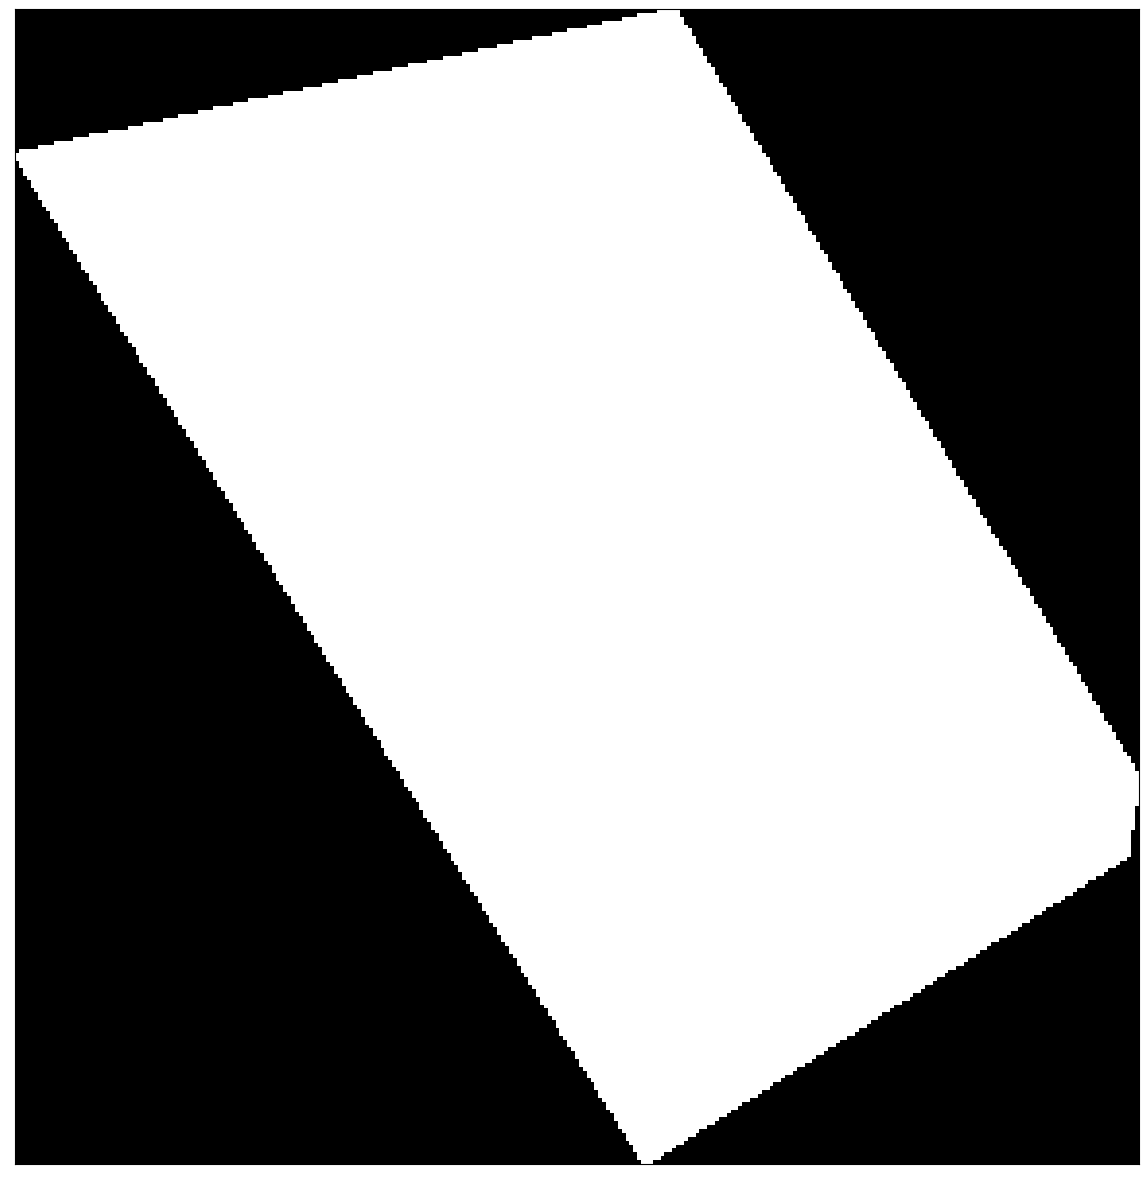

In [54]:
#visualize RGB
plot_image(all_bands_response[0][:, :, [1, 2, 3]], factor=2.5, clip_range=(0, 1))

# NDVI thresh Testing

In [7]:
from Utils.vegetation_indices import normalized_diff
from Utils.forest_cover import green_area

## AmazonSPE

### Sentinel

In [46]:
red = img_senti[:, :, 2]
nir = img_senti[:, :, 3]

In [47]:
ndvi = normalized_diff(nir, red)
g_pix, forest_area, ndvi_d = green_area(ndvi,resol,0.6,1.0)

Forest/ Green area:  10.1594 km2


In [49]:
area = poly_area(img_senti,resol)

Land area:  10.1594 km2


In [50]:
forest_cover = green_cover(forest_area,area)
print("forest_cover: ",forest_cover,"%")

forest_cover:  100.0 %


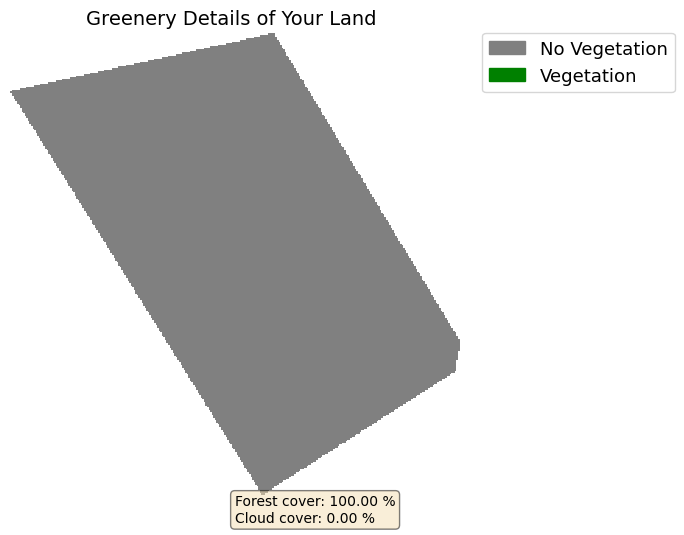

In [51]:
fig = green_cover_plot(ndvi,ndvi_d,forest_cover,cloud_cover=0)
fig.show()

### Landsat

In [13]:
red1 = all_bands_response[0][:, :, 3]
nir1 = all_bands_response[0][:, :, 0]

In [42]:
ndvi1 = normalized_diff(nir1, red1)
g_pix, forest_area, ndvi_d = green_area(ndvi1,resol,0.6,0.76)

Forest/ Green area:  10.1594 km2


In [43]:
area = poly_area(all_bands_response[0][:, :, [1, 2, 3]],resolution)

Land area:  10.1594 km2


In [44]:
forest_cover = green_cover(forest_area,area)
print("forest_cover: ",forest_cover,"%")

forest_cover:  100.0 %


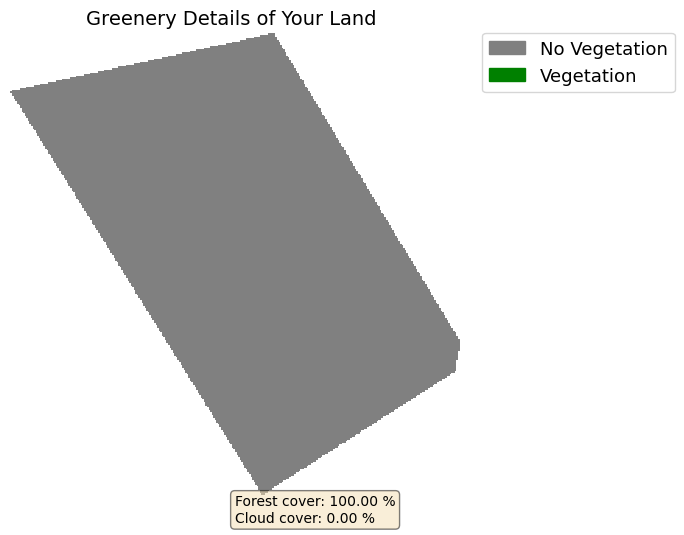

In [45]:
fig = green_cover_plot(ndvi1,ndvi_d,forest_cover,cloud_cover=0)
fig.show()